In [187]:
from moebius import olr
import matplotlib.pyplot as plt

In [49]:
from typing import Optional, Union, List, Tuple
from golem.core.optimisers.graph import OptGraph, OptNode

from golem.core.dag.graph_delegate import GraphDelegate
from golem.core.dag.linked_graph_node import LinkedGraphNode
from golem.core.dag.linked_graph import LinkedGraph

class GMMModel(GraphDelegate):
    def __init__(self, nodes: Optional[Union[LinkedGraphNode, List[LinkedGraphNode]]] = None):
        super().__init__(nodes)
        self.unique_pipeline_id = 1
    
    def find_node(self, name: str) -> Union[LinkedGraphNode, None]:
        for node in self.nodes:
            if node.content['name'] == name:
                return node
        
        return None

In [3]:
from golem.core.optimisers.graph import OptNode
from golem.core.dag.linked_graph_node import LinkedGraphNode

class GMMNode(LinkedGraphNode):
    def __str__(self):
        return self.content["name"]

In [70]:
from abc import ABC, abstractmethod
from random import choice, random, randint, uniform

class MutationStrategy(ABC):
    @abstractmethod
    def __call__(self, graph: GMMModel, **kwargs) -> GMMModel:
        pass

class SimpleMutationStrategy(MutationStrategy):
    def __init__(self, key: str):
        self.__key = key
    
    @abstractmethod
    def _mutate(self, val: float) -> float:
        pass
    
    def __call__(self, graph: GMMModel, **kwargs) -> GMMModel:
        node = choice(graph.nodes)
        node.content[self.__key] = self._mutate(node.content[self.__key])
        
        return graph

class RandomIntFromIntervalMutationStrategy(SimpleMutationStrategy):
    def __init__(self, key: str, bounds: Tuple[int, int]):
        super().__init__(key)
        self.__bounds = bounds
    
    def _mutate(self, val: float) -> float:
        l, r = self.__bounds
        
        return randint(l, r)
        
class RandomUniformFromIntervalMutationStrategy(SimpleMutationStrategy):
    def __init__(self, key: str, bounds: Tuple[float, float]):
        super().__init__(key)
        self.__bounds = bounds
    
    def _mutate(self, val: float) -> float:
        l, r = self.__bounds
        
        return uniform(l, r)
        
class RandomUniformDeltaMutationStrategy(SimpleMutationStrategy):
    def __init__(self, key: str, bounds: Tuple[float, float]):
        super().__init__(key)
        self.__bounds = bounds
    
    def _mutate(self, val: float) -> float:
        l, r = self.__bounds
        
        return val + uniform(l, r)

class GMMWeightsMutationStrategy(MutationStrategy):
    def __init__(self, key: str):
        self.__key = key
    
    def __call__(self, graph: GMMModel, **kwargs) -> GMMModel:        
        array = np.random.random(len(graph.nodes))
        array /= np.sum(array)
        
        for i, node in enumerate(graph.nodes):
            node.content[self.__key] = array[i]
        
        return graph

In [71]:
class CrossoverStrategy(ABC):
    @abstractmethod
    def __call__(self, g1: GMMModel, g2: GMMModel, **kwargs) -> (GMMModel, GMMModel):
        pass

class ExchangeCrossoverStrategy(CrossoverStrategy):
    def __init__(self, key: str):
        self.__key = key
    
    def __call__(self, g1: GMMModel, g2: GMMModel, **kwargs) -> (GMMModel, GMMModel):
        node1 = choice(g1.nodes)
        node2 = choice(g2.nodes)
        node1.content[self.__key], node2.content[self.__key] = node2.content[self.__key], node1.content[self.__key]
    
        return g1, g2

In [201]:
from math import factorial

class GMMParameters:
    def __init__(self, w: float, mean: float, var: float):
        self.w = w
        self.mean = mean
        self.var = var

class GMMSetup:
    def __init__(self, components: list[GMMParameters], target_olrs: tuple[float, ...]):
        target_olrs_len = len(target_olrs)
        components_len = len(components)
        combinations = GMMSetup.__combinations(components_len, 2)
        if target_olrs_len != combinations:
            b = "\\"
            raise ValueError(f'Illegal length of target_olrs received. It must be C^{b}2{b}_{b}{components_len}{b} = {combinations}, but {target_olrs_len} given.')
        
        self.components = components
        self.target_olrs = target_olrs
    
    def __combinations(n: int, k: int) -> int:
        if n < k:
            raise ValueError('k cannot be greater than n')
        
        return int(factorial(n) / (factorial(k) * factorial(n - k)))

class GMMOptimizerParameters:
    init: GMMSetup
    generations: int = 100
    population_size: int = 20
    timeout: int = 10
        
    crossover_prob: float = 0.8 
    mutation_prob: float = 0.9
    
    def __init__(self, init: GMMSetup):
        self.init = init
    
    def components(self) -> list[GMMParameters]:
        return self.init.components
    
    def components_len(self) -> int:
        return len(self.init.components)
    
class GMMOptimizer(ABC):
    def __init__(self, params: GMMOptimizerParameters):
        self.__params = params
        self.__objective = Objective({'custom': self._metric})
        self.__objective_eval = ObjectiveEvaluate(self.__objective)
        self.optimizer = self.__create_optimizer()
    
    def _has_no_equal_mean(self, graph):
        mean= []
        for node in graph.nodes:
            mean.append(node.content['mean'])
        mean_new = list(dict.fromkeys(mean))
        if len(mean) != len(mean_new):
            raise ValueError('Custom graph has duplicates')
        return True
    
    def _metric(self, gmm: GMMModel):
        w = []
        mean = []
        var = []
        
        for i in range(self.__params.components_len()):
            j = i + 1
            
            node = gmm.find_node(f'Comp_{j}')
            w.append(node.content['w'])
            mean.append([node.content['mean']])
            var.append([[node.content['var']]])

        return np.sum(np.subtract(olr(w, mean, var), self.__params.init.target_olrs) ** 2)
    
    def __create_optimizer(self):
        initial = [
            GMMModel(
                nodes=[
                    GMMNode(
                        nodes_from=None,
                        content={
                            'name': 'Comp_' + str(i + 1),
                            'w': comp.w,
                            'mean': comp.mean,
                            'var': comp.var
                        }
                    )
                    for i, comp in enumerate(self.__params.init.components)
                ]
            )
        ]
        
        requirements = GraphRequirements(
            max_arity=100,
            max_depth=100, 
            early_stopping_iterations=6,
            num_of_generations=self.__params.generations,
            timeout=timedelta(minutes=self.__params.timeout),
            history_dir = None,
            n_jobs=-1,
        )
        
        optimiser_parameters = GPAlgorithmParameters(
            pop_size=self.__params.population_size,
            crossover_prob=self.__params.crossover_prob, 
            mutation_prob=self.__params.mutation_prob,
            genetic_scheme_type = GeneticSchemeTypesEnum.steady_state,
            selection_types = [SelectionTypesEnum.tournament],
            mutation_types = [
                GMMWeightsMutationStrategy('w'),
                RandomIntFromIntervalMutationStrategy('mean', (0, 20)),
                RandomUniformDeltaMutationStrategy('var', (-0.1, 0.1))
            ],
            crossover_types = [
                ExchangeCrossoverStrategy('mean'),
                ExchangeCrossoverStrategy('var')
            ]
        )
        rules = [self._has_no_equal_mean]
        graph_generation_params = GraphGenerationParams(
            adapter=DirectAdapter(base_graph_class=GMMModel, base_node_class=GMMNode),
            rules_for_constraint=rules
        )
        
        return EvoGraphOptimizer(
            graph_generation_params=graph_generation_params,
            graph_optimizer_params=optimiser_parameters,
            requirements=requirements,
            initial_graphs=initial,
            objective=self.__objective
        )
    
    def optimize(self):
        return self.optimizer.optimise(self.__objective_eval)[0]

In [202]:
setup = GMMSetup(
    [
        GMMParameters(1 / 3, 12, 0.5),
        GMMParameters(1 / 3, 6, 0.5),
        GMMParameters(1 / 3, 10, 0.5)
    ],
    [
        0.4,
        0.8,
        0.2
    ]
)

optimizer = GMMOptimizer(GMMOptimizerParameters(setup))
res = optimizer.optimize()

Generations:   1%|          | 1/100 [00:00<?, ?gen/s]

2023-05-23 15:31:38,411 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-05-23 15:31:39,118 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-05-23 15:31:39,120 - EvoGraphOptimizer - Generation num: 1 size: 1
2023-05-23 15:31:39,120 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<custom=0.193>']
2023-05-23 15:31:39,276 - EvoGraphOptimizer - Exceeded max number of attempts for extending initial graphs, stopping.Current size 1 instead of 20 graphs.
2023-05-23 15:31:39,277 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-05-23 15:31:39,278 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-05-23 15:31:39,278 - EvoGraphOptimizer - Generation num: 2 size: 1
2023-05-23 15:31:39,279 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<custom=0.193>']
2023-05-23 15:31:39,279 - EvoGraphOptimizer - no improveme

2023-05-23 15:31:48,909 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<custom=0.036>']
2023-05-23 15:31:48,910 - EvoGraphOptimizer - Next population size: 55; max graph depth: 100
2023-05-23 15:31:48,931 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-05-23 15:31:49,762 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2023-05-23 15:31:49,766 - EvoGraphOptimizer - Generation num: 16 size: 55
2023-05-23 15:31:49,766 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<custom=0.036>']
2023-05-23 15:31:49,766 - EvoGraphOptimizer - no improvements for 1 iterations
2023-05-23 15:31:49,767 - EvoGraphOptimizer - spent time: 0.2 min
2023-05-23 15:31:49,768 - EvoGraphOptimizer - Next population size: 55; max graph depth: 100
2023-05-23 15:31:49,789 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-05-23 15:31:50,630 - MultiprocessingDispatcher - 54 individuals out of 54

2023-05-23 15:32:03,020 - EvoGraphOptimizer - Generation num: 30 size: 55
2023-05-23 15:32:03,020 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<custom=0.029>']
2023-05-23 15:32:03,021 - EvoGraphOptimizer - no improvements for 1 iterations
2023-05-23 15:32:03,021 - EvoGraphOptimizer - spent time: 0.4 min
2023-05-23 15:32:03,022 - EvoGraphOptimizer - Next population size: 55; max graph depth: 100
2023-05-23 15:32:03,046 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-05-23 15:32:04,035 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2023-05-23 15:32:04,039 - EvoGraphOptimizer - Generation num: 31 size: 55
2023-05-23 15:32:04,039 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<custom=0.029>']
2023-05-23 15:32:04,039 - EvoGraphOptimizer - no improvements for 2 iterations
2023-05-23 15:32:04,040 - EvoGraphOptimizer - spent time: 0.4 min
2023-05-23 15:32:04,040 - EvoG

Generations:   1%|          | 1/100 [00:34<?, ?gen/s]

2023-05-23 15:32:12,658 - OptimisationTimer - Composition time: 0.571 min
2023-05-23 15:32:12,658 - EvoGraphOptimizer - Generation num: 40 size: 1
2023-05-23 15:32:12,659 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<custom=0.026>']
2023-05-23 15:32:12,659 - EvoGraphOptimizer - no improvements for 7 iterations
2023-05-23 15:32:12,660 - EvoGraphOptimizer - spent time: 0.6 min


In [204]:
for node in res.nodes:    
    print(node.content['name'] + ' (w: ' + str(round(node.content['w'], 4)) + ', mean: ' + str(round(node.content['mean'], 4)) + ', var: ' + str(round(node.content['var'], 4)) + ')')

w = []
mean = []
var = []

for node in res.nodes:
    w.append(node.content['w'])
    mean.append([node.content['mean']])
    var.append([[node.content['var']]])

olr(w, mean, var)

Comp_1 (w: 0.373, mean: 12, var: 0.4689)
Comp_2 (w: 0.1379, mean: 15, var: 0.6628)
Comp_3 (w: 0.4891, mean: 10, var: 0.7317)


[0.4268838524218012, 0.8207626223622377, 0.041173839443984825]

2023-05-23 15:32:44,273 - FitnessLine - Visualizing optimization history... It may take some time, depending on the history size.


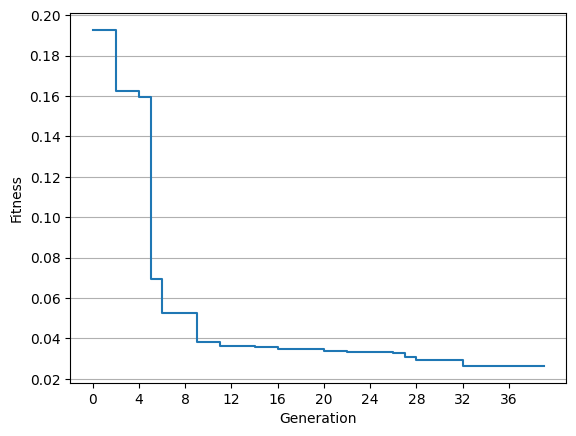

In [205]:
optimizer.optimizer._history.show()